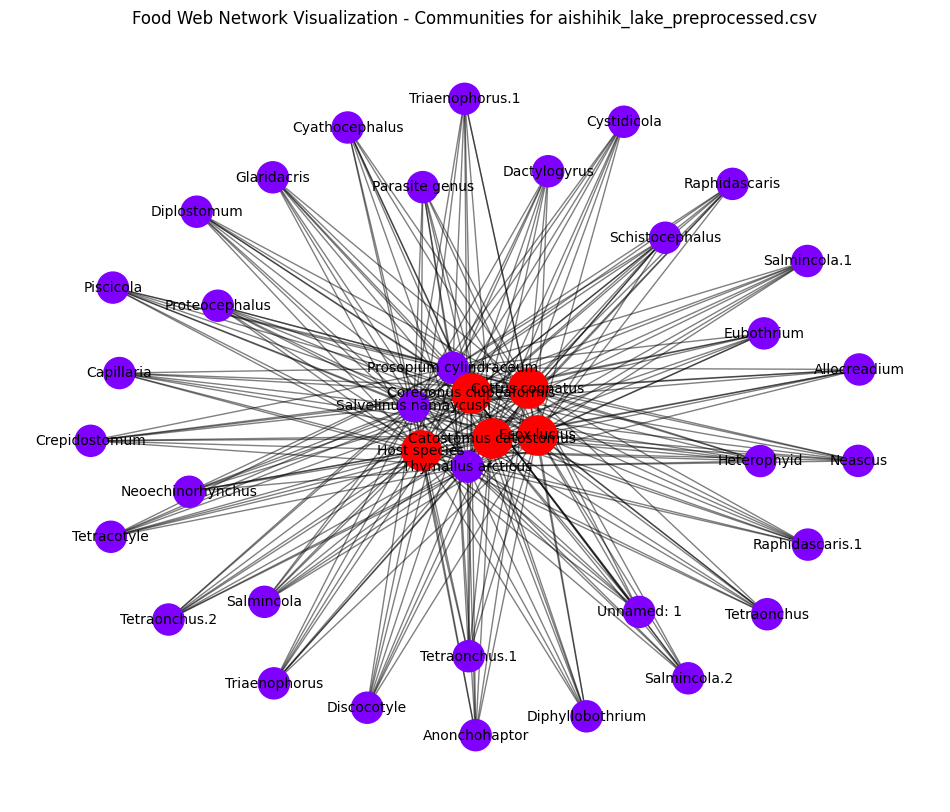

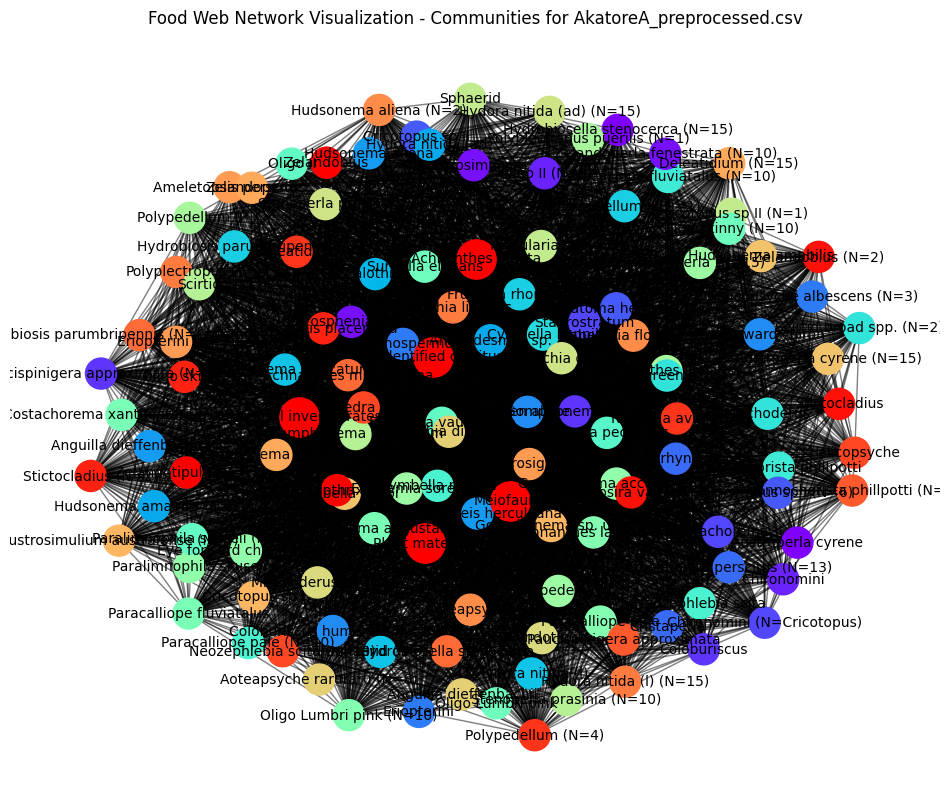

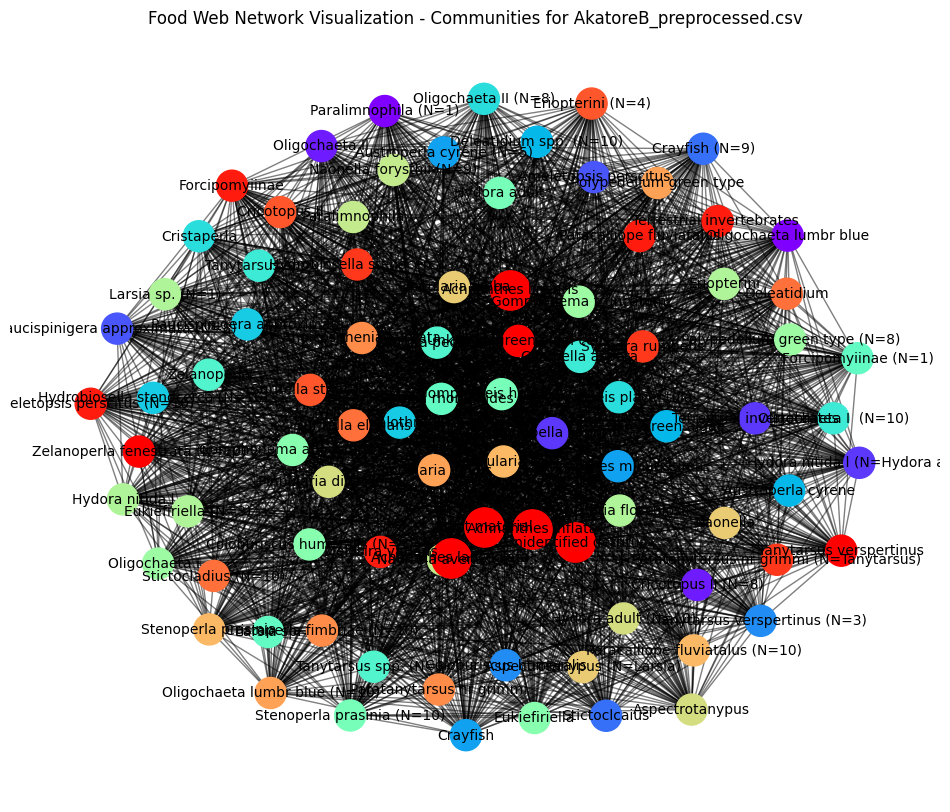

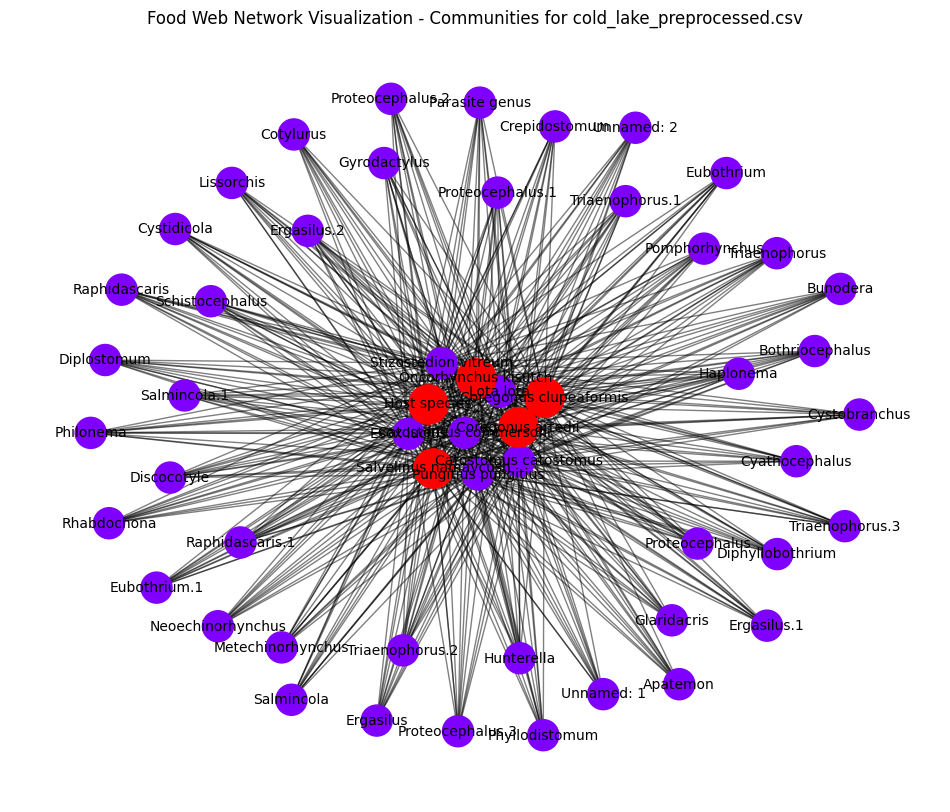

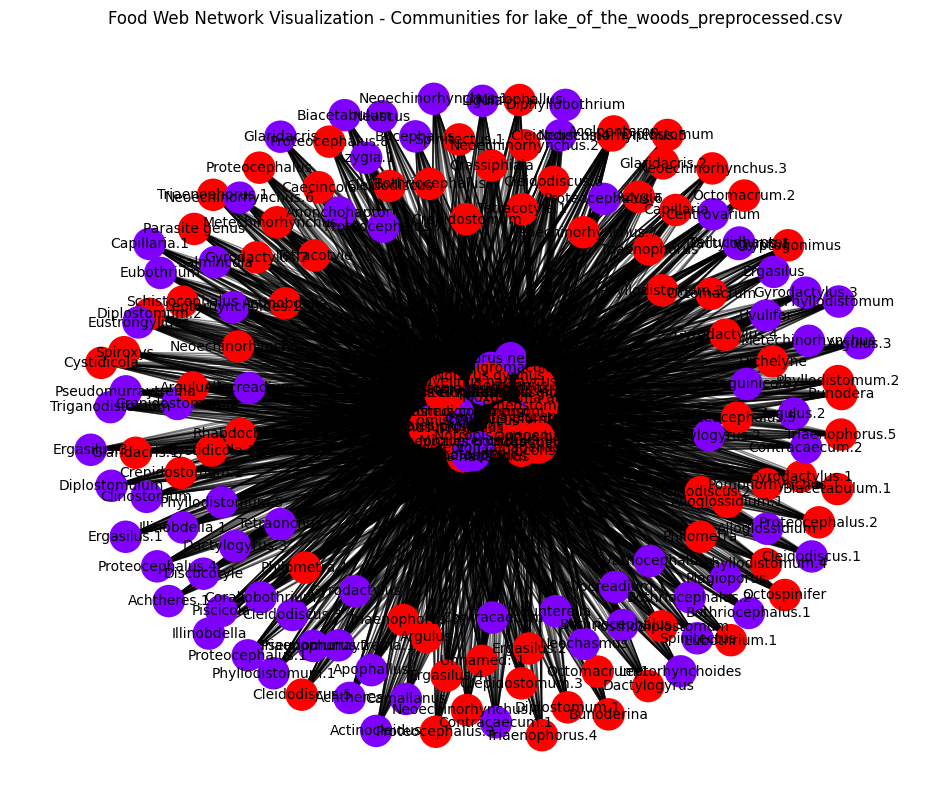

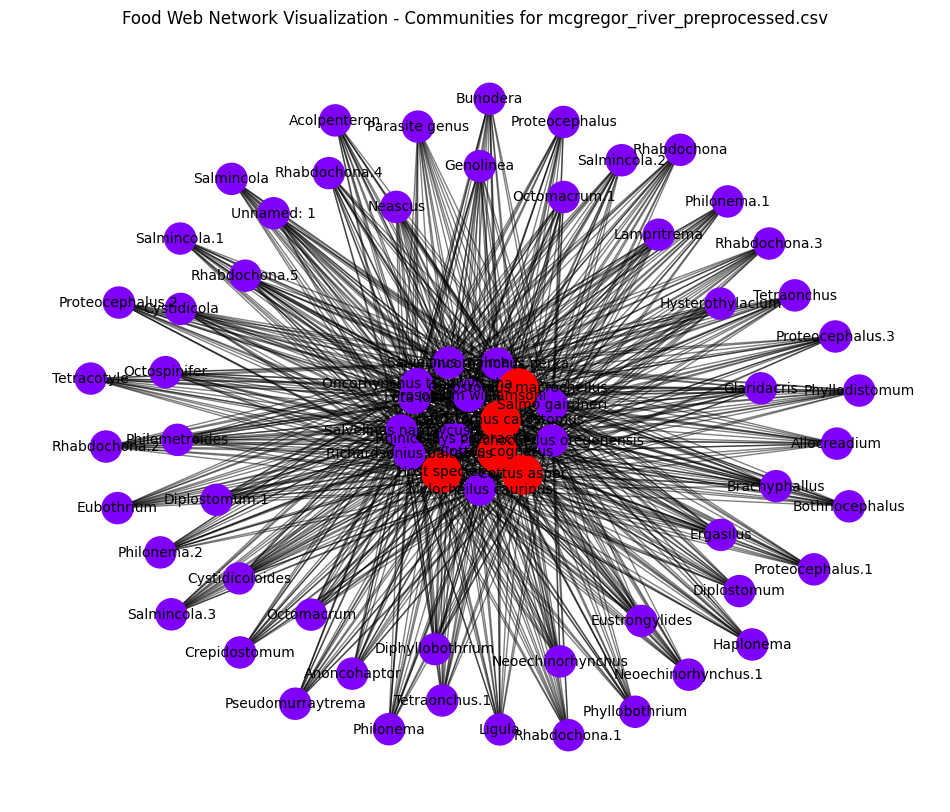

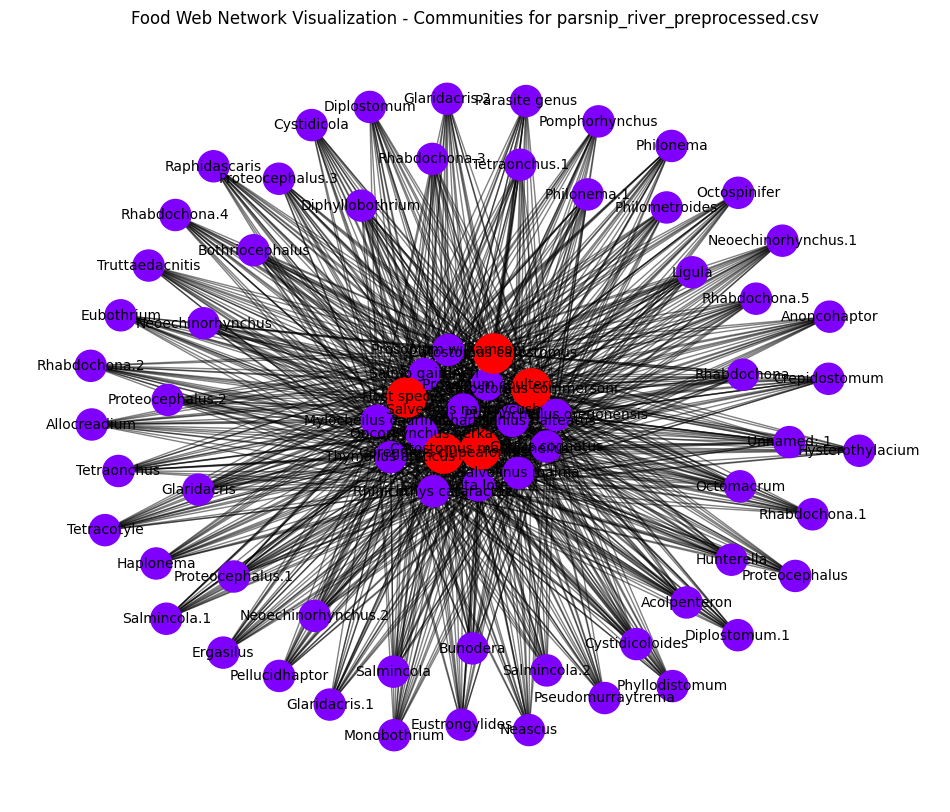

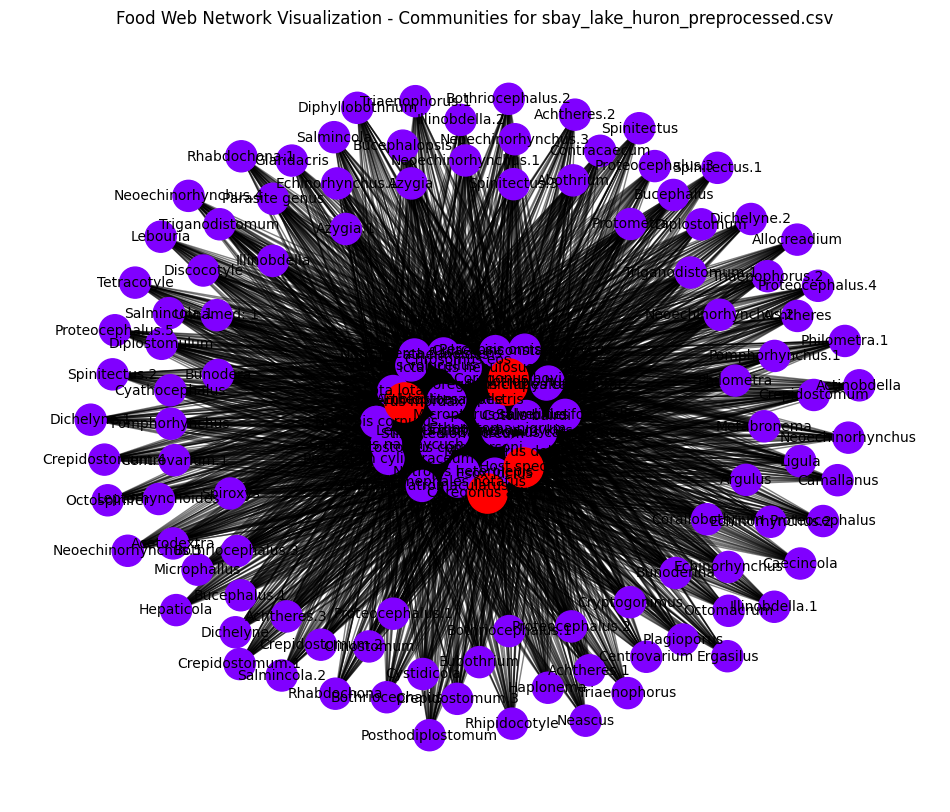

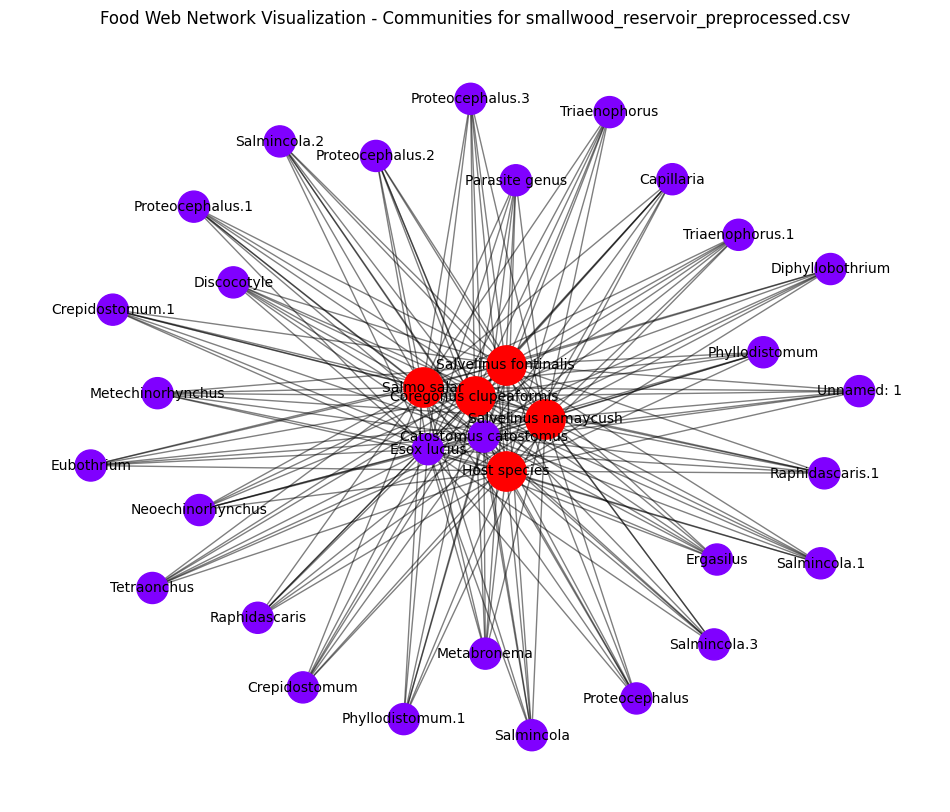

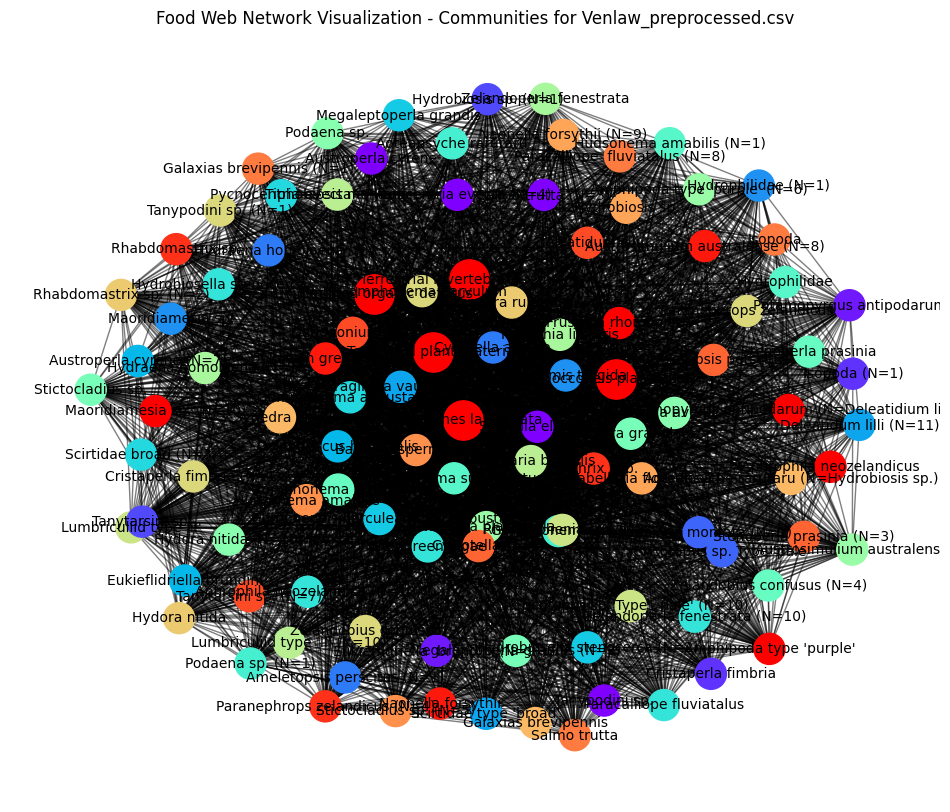

In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from community import community_louvain  # Install this using pip if not already installed

# List of file paths
file_paths = [
    'datacleaning/aishihik_lake_preprocessed.csv',
    'datacleaning/AkatoreA_preprocessed.csv',
    'datacleaning/AkatoreB_preprocessed.csv',
    'datacleaning/cold_lake_preprocessed.csv',
    'datacleaning/lake_of_the_woods_preprocessed.csv',
    'datacleaning/mcgregor_river_preprocessed.csv',
    'datacleaning/parsnip_river_preprocessed.csv',
    'datacleaning/sbay_lake_huron_preprocessed.csv',
    'datacleaning/smallwood_reservoir_preprocessed.csv',
    'datacleaning/Venlaw_preprocessed.csv'
]

# Function to visualize the food web network with community detection and key species
def visualize_food_web(file_path):
    # Read the CSV into a pandas DataFrame
    edge_list = pd.read_csv(file_path)
    
    # Create a graph from the edge list (assuming the CSV has columns 'source' and 'target')
    G = nx.from_pandas_edgelist(edge_list, source='source', target='target')

    # Community detection using the Louvain method
    partition = community_louvain.best_partition(G)

    # Prepare the layout for visualization (Force-directed layout)
    pos = nx.spring_layout(G)  # This is a force-directed layout
    
    # Step 1: Draw the graph with community-based coloring
    plt.figure(figsize=(12, 10))
    
    # Node color based on communities
    community_colors = [partition[node] for node in G.nodes()]
    nx.draw_networkx_nodes(G, pos, node_size=500, cmap=plt.cm.rainbow, node_color=community_colors)
    
    # Draw the edges
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
    
    # Draw the labels (node identifiers)
    nx.draw_networkx_labels(G, pos, font_size=10, font_color='black')

    # Step 2: Highlight key species (e.g., nodes with high degree)
    # For this example, highlight the top 5 nodes with the highest degree
    deg = dict(G.degree())
    key_species = sorted(deg, key=deg.get, reverse=True)[:5]  # Top 5 key species based on degree centrality

    # Draw key species with a different color and size
    nx.draw_networkx_nodes(G, pos, nodelist=key_species, node_size=800, node_color='red')

    # Step 3: Title and display the plot
    plt.title(f"Food Web Network Visualization - Communities for {file_path.split('/')[-1]}")
    plt.axis('off')  # Hide axes for a cleaner look
    plt.show()

    # Optional: Save the figure to a file
    # plt.savefig(f"food_web_visualization_{file_path.split('/')[-1].split('.')[0]}.png")

# Loop through all files and visualize the food web networks
for file_path in file_paths:
    visualize_food_web(file_path)


In [1]:
import networkx as nx
import pandas as pd
import numpy as np
from itertools import permutations
import random
from multiprocessing import Pool, cpu_count
from functools import partial

def sample_motifs(G, sample_size=1000):
    """
    Sample network motifs using a faster sampling approach
    """
    nodes = list(G.nodes())
    n = len(nodes)
    if n < 3:
        return [], []
    
    # Pre-compute adjacency for faster lookup
    adj = {node: set(G.successors(node)) for node in G.nodes()}
    
    ffls = set()
    fbls = set()
    
    # Sample random node triplets instead of checking all combinations
    samples = [random.sample(nodes, 3) for _ in range(sample_size)]
    
    for nodes in samples:
        # Check for feed-forward loops
        if (nodes[1] in adj[nodes[0]] and 
            nodes[2] in adj[nodes[1]] and 
            nodes[2] in adj[nodes[0]]):
            ffls.add(tuple(sorted(nodes)))
            
        # Check for feedback loops
        if (nodes[1] in adj[nodes[0]] and 
            nodes[2] in adj[nodes[1]] and 
            nodes[0] in adj[nodes[2]]):
            fbls.add(tuple(sorted(nodes)))
    
    # Extrapolate counts based on sampling ratio
    total_combinations = n * (n-1) * (n-2)
    scaling_factor = total_combinations / sample_size
    
    return list(ffls), list(fbls), scaling_factor

def generate_random_network(args):
    """
    Generate a single random network (for parallel processing)
    """
    G, seed = args
    random.seed(seed)
    try:
        RG = nx.directed_configuration_model(
            [d for _, d in G.in_degree()],
            [d for _, d in G.out_degree()]
        )
        RG = nx.DiGraph(RG)
        RG.remove_edges_from(nx.selfloop_edges(RG))
        return RG
    except:
        return nx.gnm_random_graph(G.number_of_nodes(), G.number_of_edges(), directed=True)

def calculate_network_properties(file_path):
    """
    Calculate network properties with optimized motif analysis
    """
    # Read and create network
    edge_list = pd.read_csv(file_path)
    G = nx.from_pandas_edgelist(edge_list, source='source', target='target', create_using=nx.DiGraph())
    
    # Basic network metrics
    n_nodes = G.number_of_nodes()
    n_edges = G.number_of_edges()
    mean_degree = 2 * n_edges / n_nodes
    clustering_coeff = nx.average_clustering(G.to_undirected())
    
    # Motif sampling
    ffls, fbls, scaling_factor = sample_motifs(G, sample_size=1000)
    
    # Parallel random network generation (reduced to 100 networks)
    n_random = 100
    with Pool(processes=cpu_count()) as pool:
        random_networks = pool.map(
            generate_random_network,
            [(G, i) for i in range(n_random)]
        )
    
    # Calculate motif statistics for random networks
    random_ffl_counts = []
    random_fbl_counts = []
    
    for RG in random_networks:
        rand_ffls, rand_fbls, rand_scale = sample_motifs(RG, sample_size=1000)
        random_ffl_counts.append(len(rand_ffls) * rand_scale)
        random_fbl_counts.append(len(rand_fbls) * rand_scale)
    
    # Calculate statistics
    ffl_stats = {
        'count': len(ffls) * scaling_factor,
        'mean_random': np.mean(random_ffl_counts),
        'std_random': np.std(random_ffl_counts),
        'z_score': (len(ffls) * scaling_factor - np.mean(random_ffl_counts)) / (np.std(random_ffl_counts) + 1e-10),
        'p_value': sum(count >= len(ffls) * scaling_factor for count in random_ffl_counts) / len(random_ffl_counts)
    }
    
    fbl_stats = {
        'count': len(fbls) * scaling_factor,
        'mean_random': np.mean(random_fbl_counts),
        'std_random': np.std(random_fbl_counts),
        'z_score': (len(fbls) * scaling_factor - np.mean(random_fbl_counts)) / (np.std(random_fbl_counts) + 1e-10),
        'p_value': sum(count >= len(fbls) * scaling_factor for count in random_fbl_counts) / len(random_fbl_counts)
    }
    
    results = f"""
    Results for {file_path}:
    ------------------------------
    Network Properties:
      Nodes: {n_nodes}
      Edges: {n_edges}
      Mean Degree: {mean_degree:.2f}
      Clustering Coefficient: {clustering_coeff:.4f}
    
    Motif Analysis (Estimated):
      Feed-Forward Loops (FFL):
        Estimated Count: {ffl_stats['count']:.1f}
        Random Mean: {ffl_stats['mean_random']:.1f} ± {ffl_stats['std_random']:.1f}
        Z-score: {ffl_stats['z_score']:.4f}
        P-value: {ffl_stats['p_value']:.4f}
        
      Feedback Loops (FBL):
        Estimated Count: {fbl_stats['count']:.1f}
        Random Mean: {fbl_stats['mean_random']:.1f} ± {fbl_stats['std_random']:.1f}
        Z-score: {fbl_stats['z_score']:.4f}
        P-value: {fbl_stats['p_value']:.4f}
    ------------------------------
    """
    
    return results

# File paths
file_paths = [
    'datacleaning/aishihik_lake_preprocessed.csv',
    'datacleaning/AkatoreA_preprocessed.csv',
    'datacleaning/AkatoreB_preprocessed.csv',
    'datacleaning/cold_lake_preprocessed.csv',
    'datacleaning/lake_of_the_woods_preprocessed.csv',
    'datacleaning/mcgregor_river_preprocessed.csv',
    'datacleaning/parsnip_river_preprocessed.csv',
    'datacleaning/sbay_lake_huron_preprocessed.csv',
    'datacleaning/smallwood_reservoir_preprocessed.csv',
    'datacleaning/Venlaw_preprocessed.csv'
]

# Process all files
for file_path in file_paths:
    result = calculate_network_properties(file_path)
    print(result)



    Results for datacleaning/aishihik_lake_preprocessed.csv:
    ------------------------------
    Network Properties:
      Nodes: 39
      Edges: 248
      Mean Degree: 12.72
      Clustering Coefficient: 0.0000
    
    Motif Analysis (Estimated):
      Feed-Forward Loops (FFL):
        Estimated Count: 0.0
        Random Mean: 0.0 ± 0.0
        Z-score: 0.0000
        P-value: 1.0000
        
      Feedback Loops (FBL):
        Estimated Count: 0.0
        Random Mean: 0.0 ± 0.0
        Z-score: 0.0000
        P-value: 1.0000
    ------------------------------
    

    Results for datacleaning/AkatoreA_preprocessed.csv:
    ------------------------------
    Network Properties:
      Nodes: 126
      Edges: 7225
      Mean Degree: 114.68
      Clustering Coefficient: 0.7766
    
    Motif Analysis (Estimated):
      Feed-Forward Loops (FFL):
        Estimated Count: 330057.0
        Random Mean: 78862.1 ± 13030.4
        Z-score: 19.2776
        P-value: 0.0000
        
      Fe

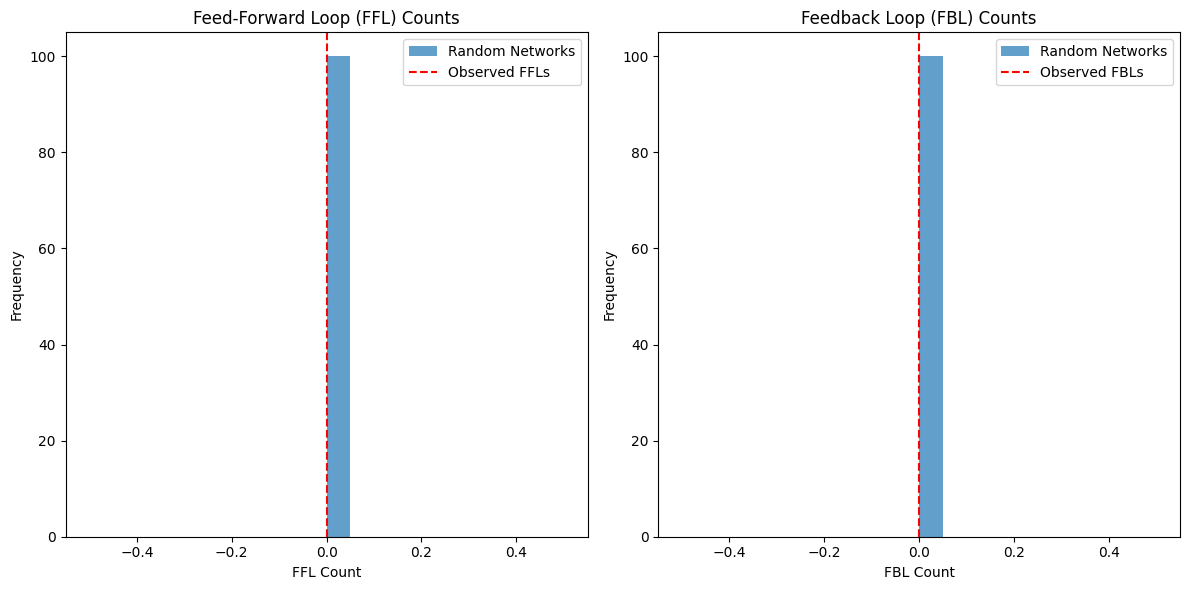


    Results for datacleaning/aishihik_lake_preprocessed.csv:
    ------------------------------
    Network Properties:
      Nodes: 39
      Edges: 248
      Mean Degree: 12.72
      Clustering Coefficient: 0.0000
    
    Motif Analysis (Estimated):
      Feed-Forward Loops (FFL):
        Estimated Count: 0.0
        Random Mean: 0.0 ± 0.0
        Z-score: 0.0000
        P-value: 1.0000
        
      Feedback Loops (FBL):
        Estimated Count: 0.0
        Random Mean: 0.0 ± 0.0
        Z-score: 0.0000
        P-value: 1.0000
    ------------------------------
    


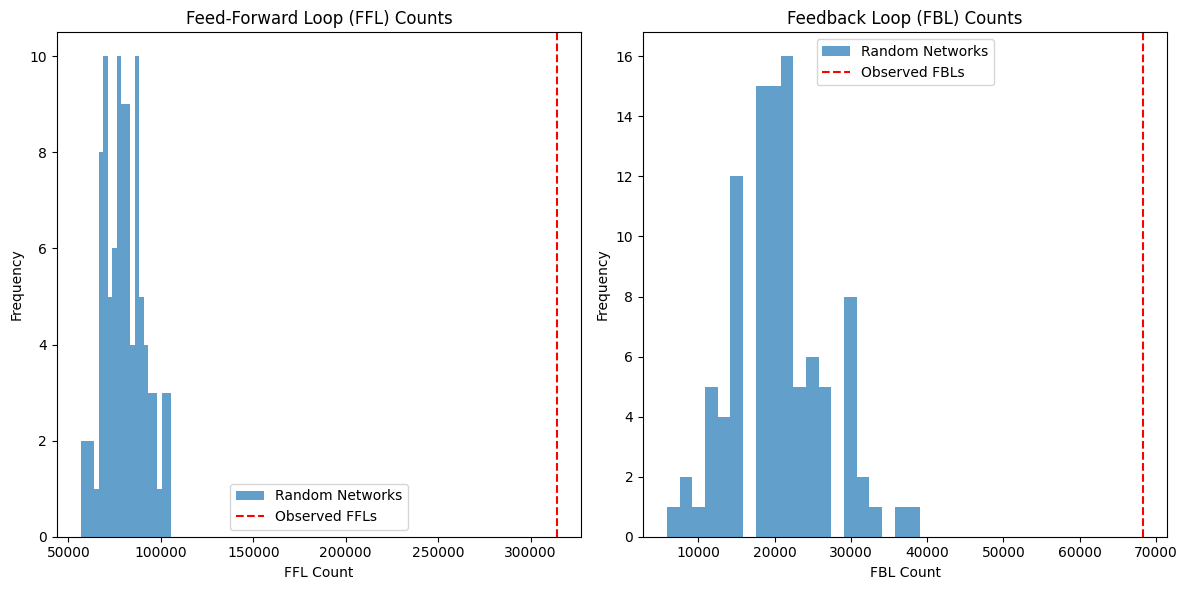


    Results for datacleaning/AkatoreA_preprocessed.csv:
    ------------------------------
    Network Properties:
      Nodes: 126
      Edges: 7225
      Mean Degree: 114.68
      Clustering Coefficient: 0.7766
    
    Motif Analysis (Estimated):
      Feed-Forward Loops (FFL):
        Estimated Count: 314433.0
        Random Mean: 80112.1 ± 10957.6
        Z-score: 21.3843
        P-value: 0.0000
        
      Feedback Loops (FBL):
        Estimated Count: 68355.0
        Random Mean: 20447.9 ± 6098.0
        Z-score: 7.8562
        P-value: 0.0000
    ------------------------------
    


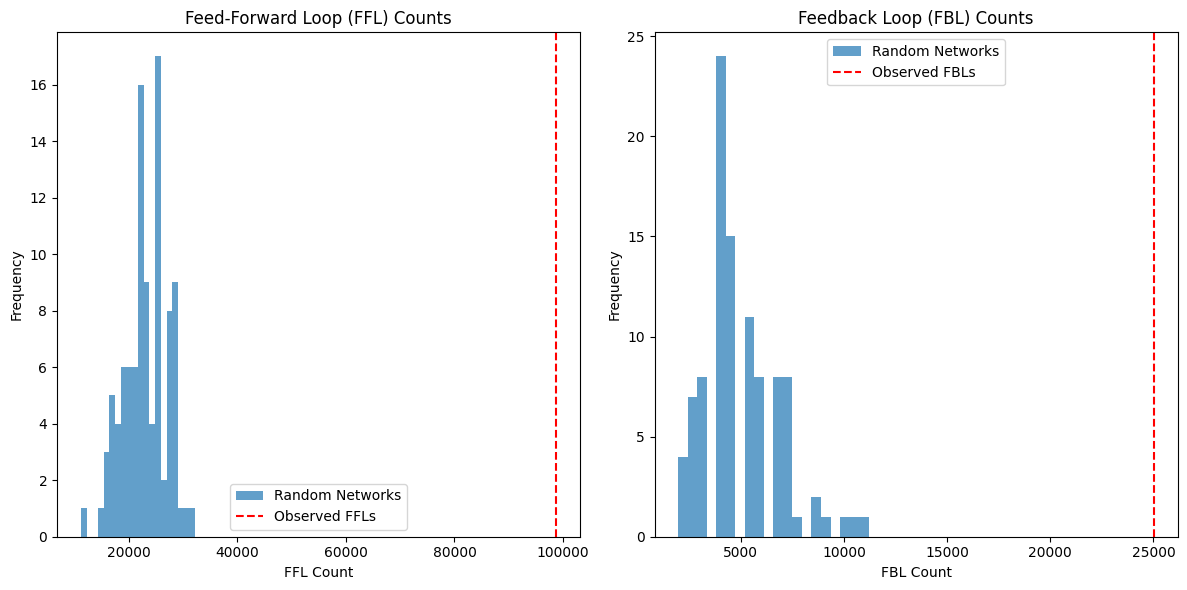


    Results for datacleaning/AkatoreB_preprocessed.csv:
    ------------------------------
    Network Properties:
      Nodes: 88
      Edges: 3364
      Mean Degree: 76.45
      Clustering Coefficient: 0.7466
    
    Motif Analysis (Estimated):
      Feed-Forward Loops (FFL):
        Estimated Count: 98762.4
        Random Mean: 23097.2 ± 3993.8
        Z-score: 18.9456
        P-value: 0.0000
        
      Feedback Loops (FBL):
        Estimated Count: 25019.8
        Random Mean: 4984.2 ± 1844.2
        Z-score: 10.8643
        P-value: 0.0000
    ------------------------------
    


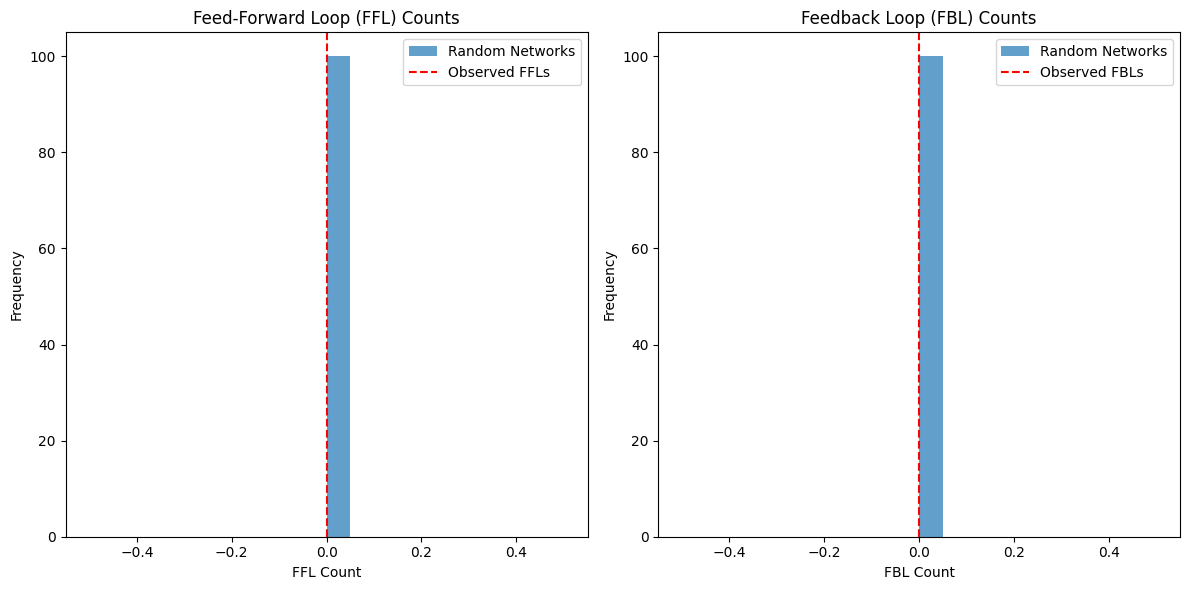


    Results for datacleaning/cold_lake_preprocessed.csv:
    ------------------------------
    Network Properties:
      Nodes: 54
      Edges: 473
      Mean Degree: 17.52
      Clustering Coefficient: 0.0000
    
    Motif Analysis (Estimated):
      Feed-Forward Loops (FFL):
        Estimated Count: 0.0
        Random Mean: 0.0 ± 0.0
        Z-score: 0.0000
        P-value: 1.0000
        
      Feedback Loops (FBL):
        Estimated Count: 0.0
        Random Mean: 0.0 ± 0.0
        Z-score: 0.0000
        P-value: 1.0000
    ------------------------------
    


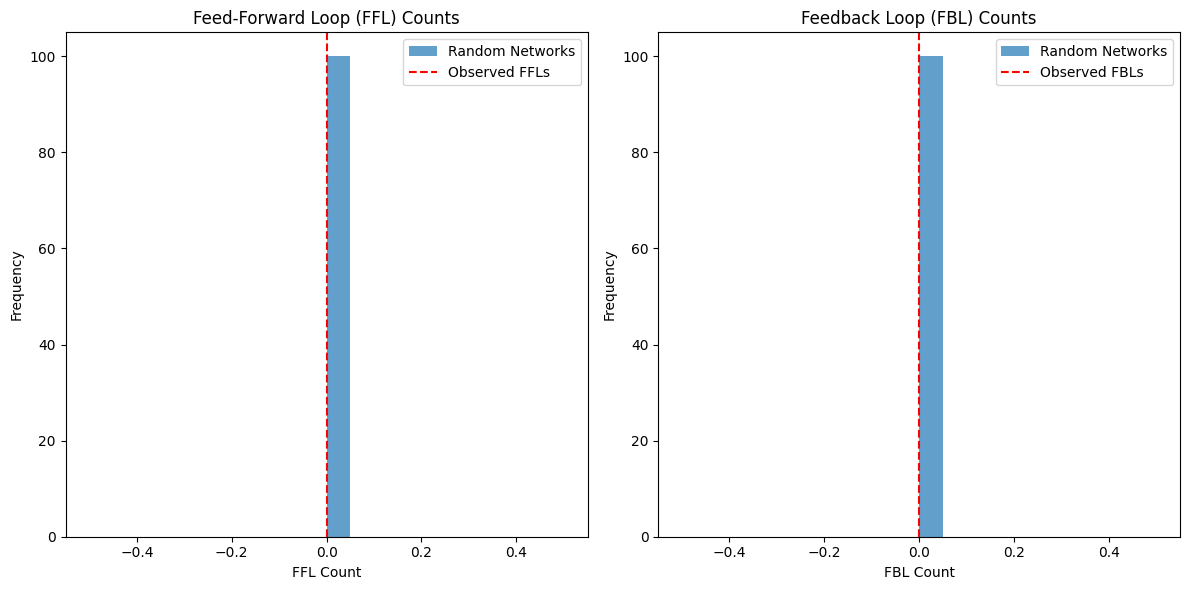


    Results for datacleaning/lake_of_the_woods_preprocessed.csv:
    ------------------------------
    Network Properties:
      Nodes: 178
      Edges: 4672
      Mean Degree: 52.49
      Clustering Coefficient: 0.0000
    
    Motif Analysis (Estimated):
      Feed-Forward Loops (FFL):
        Estimated Count: 0.0
        Random Mean: 0.0 ± 0.0
        Z-score: 0.0000
        P-value: 1.0000
        
      Feedback Loops (FBL):
        Estimated Count: 0.0
        Random Mean: 0.0 ± 0.0
        Z-score: 0.0000
        P-value: 1.0000
    ------------------------------
    


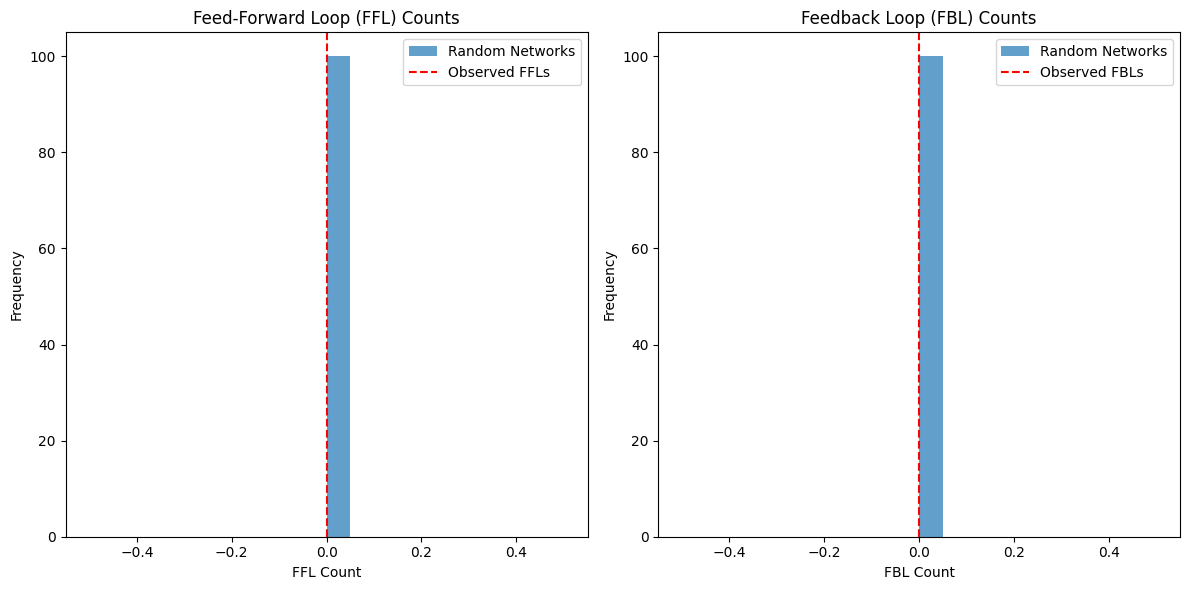


    Results for datacleaning/mcgregor_river_preprocessed.csv:
    ------------------------------
    Network Properties:
      Nodes: 69
      Edges: 848
      Mean Degree: 24.58
      Clustering Coefficient: 0.0000
    
    Motif Analysis (Estimated):
      Feed-Forward Loops (FFL):
        Estimated Count: 0.0
        Random Mean: 0.0 ± 0.0
        Z-score: 0.0000
        P-value: 1.0000
        
      Feedback Loops (FBL):
        Estimated Count: 0.0
        Random Mean: 0.0 ± 0.0
        Z-score: 0.0000
        P-value: 1.0000
    ------------------------------
    


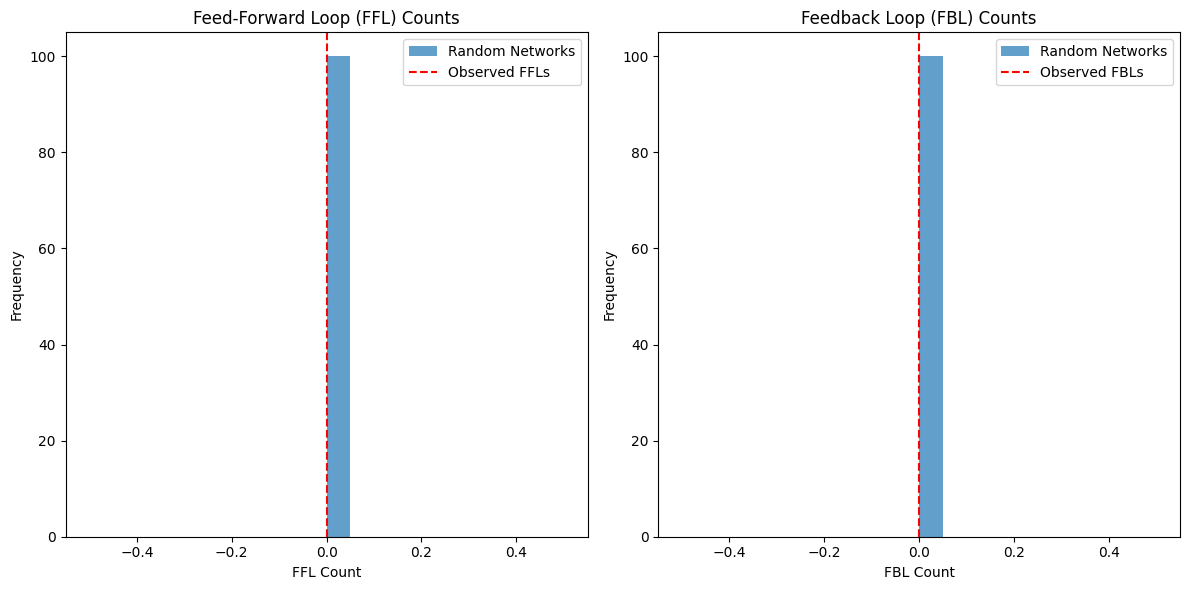


    Results for datacleaning/parsnip_river_preprocessed.csv:
    ------------------------------
    Network Properties:
      Nodes: 73
      Edges: 990
      Mean Degree: 27.12
      Clustering Coefficient: 0.0000
    
    Motif Analysis (Estimated):
      Feed-Forward Loops (FFL):
        Estimated Count: 0.0
        Random Mean: 0.0 ± 0.0
        Z-score: 0.0000
        P-value: 1.0000
        
      Feedback Loops (FBL):
        Estimated Count: 0.0
        Random Mean: 0.0 ± 0.0
        Z-score: 0.0000
        P-value: 1.0000
    ------------------------------
    


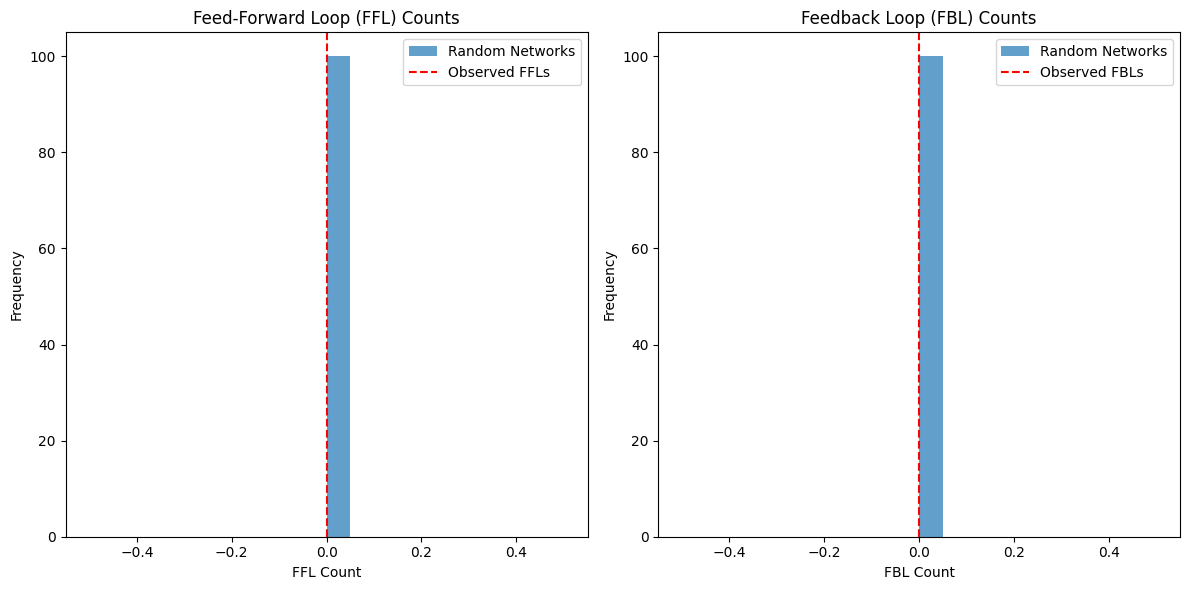


    Results for datacleaning/sbay_lake_huron_preprocessed.csv:
    ------------------------------
    Network Properties:
      Nodes: 133
      Edges: 3366
      Mean Degree: 50.62
      Clustering Coefficient: 0.0000
    
    Motif Analysis (Estimated):
      Feed-Forward Loops (FFL):
        Estimated Count: 0.0
        Random Mean: 0.0 ± 0.0
        Z-score: 0.0000
        P-value: 1.0000
        
      Feedback Loops (FBL):
        Estimated Count: 0.0
        Random Mean: 0.0 ± 0.0
        Z-score: 0.0000
        P-value: 1.0000
    ------------------------------
    


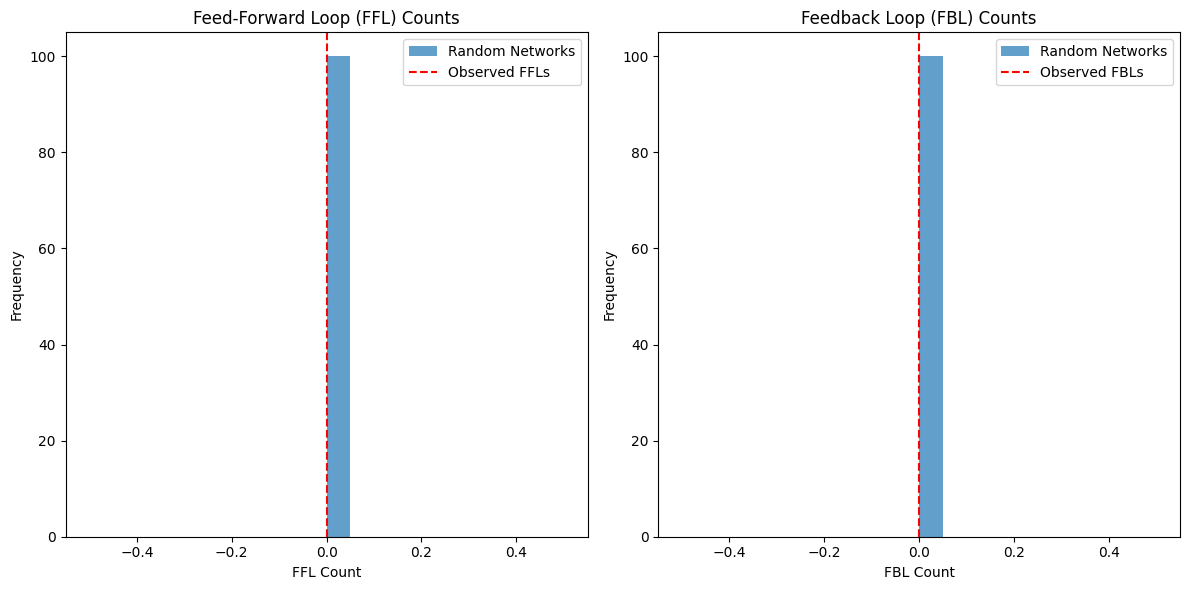


    Results for datacleaning/smallwood_reservoir_preprocessed.csv:
    ------------------------------
    Network Properties:
      Nodes: 34
      Edges: 189
      Mean Degree: 11.12
      Clustering Coefficient: 0.0000
    
    Motif Analysis (Estimated):
      Feed-Forward Loops (FFL):
        Estimated Count: 0.0
        Random Mean: 0.0 ± 0.0
        Z-score: 0.0000
        P-value: 1.0000
        
      Feedback Loops (FBL):
        Estimated Count: 0.0
        Random Mean: 0.0 ± 0.0
        Z-score: 0.0000
        P-value: 1.0000
    ------------------------------
    


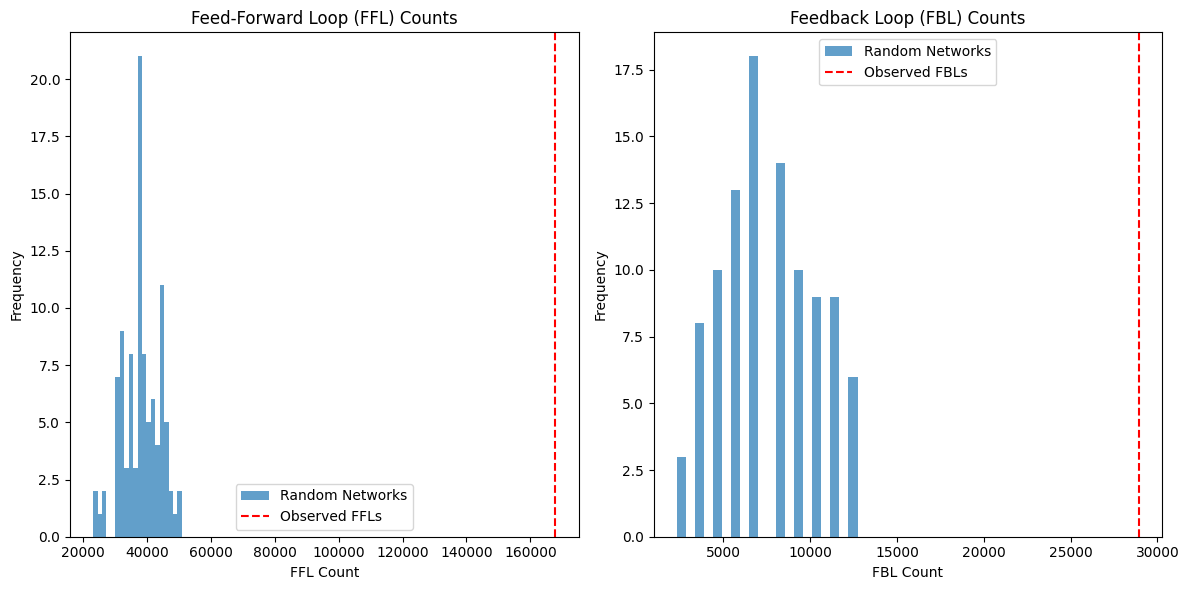


    Results for datacleaning/Venlaw_preprocessed.csv:
    ------------------------------
    Network Properties:
      Nodes: 106
      Edges: 4761
      Mean Degree: 89.83
      Clustering Coefficient: 0.7282
    
    Motif Analysis (Estimated):
      Feed-Forward Loops (FFL):
        Estimated Count: 167840.4
        Random Mean: 38128.7 ± 5693.8
        Z-score: 22.7811
        P-value: 0.0000
        
      Feedback Loops (FBL):
        Estimated Count: 28938.0
        Random Mean: 7616.5 ± 2759.6
        Z-score: 7.7264
        P-value: 0.0000
    ------------------------------
    


In [2]:
import matplotlib.pyplot as plt

def plot_motif_distribution(ffls, fbls, random_ffl_counts, random_fbl_counts, scaling_factor):
    """
    Plot histograms for feed-forward loops (FFLs) and feedback loops (FBLs),
    and compare observed motif counts with random networks.
    """
    # Plot feed-forward loops (FFLs)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.hist(random_ffl_counts, bins=20, alpha=0.7, label="Random Networks")
    plt.axvline(x=len(ffls) * scaling_factor, color='r', linestyle='--', label="Observed FFLs")
    plt.title("Feed-Forward Loop (FFL) Counts")
    plt.xlabel("FFL Count")
    plt.ylabel("Frequency")
    plt.legend()
    
    # Plot feedback loops (FBLs)
    plt.subplot(1, 2, 2)
    plt.hist(random_fbl_counts, bins=20, alpha=0.7, label="Random Networks")
    plt.axvline(x=len(fbls) * scaling_factor, color='r', linestyle='--', label="Observed FBLs")
    plt.title("Feedback Loop (FBL) Counts")
    plt.xlabel("FBL Count")
    plt.ylabel("Frequency")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def calculate_network_properties(file_path):
    """
    Calculate network properties with optimized motif analysis and visualizations.
    """
    # Read and create network
    edge_list = pd.read_csv(file_path)
    G = nx.from_pandas_edgelist(edge_list, source='source', target='target', create_using=nx.DiGraph())
    
    # Basic network metrics
    n_nodes = G.number_of_nodes()
    n_edges = G.number_of_edges()
    mean_degree = 2 * n_edges / n_nodes
    clustering_coeff = nx.average_clustering(G.to_undirected())
    
    # Motif sampling
    ffls, fbls, scaling_factor = sample_motifs(G, sample_size=1000)
    
    # Parallel random network generation (reduced to 100 networks)
    n_random = 100
    with Pool(processes=cpu_count()) as pool:
        random_networks = pool.map(
            generate_random_network,
            [(G, i) for i in range(n_random)]
        )
    
    # Calculate motif statistics for random networks
    random_ffl_counts = []
    random_fbl_counts = []
    
    for RG in random_networks:
        rand_ffls, rand_fbls, rand_scale = sample_motifs(RG, sample_size=1000)
        random_ffl_counts.append(len(rand_ffls) * rand_scale)
        random_fbl_counts.append(len(rand_fbls) * rand_scale)
    
    # Calculate statistics
    ffl_stats = {
        'count': len(ffls) * scaling_factor,
        'mean_random': np.mean(random_ffl_counts),
        'std_random': np.std(random_ffl_counts),
        'z_score': (len(ffls) * scaling_factor - np.mean(random_ffl_counts)) / (np.std(random_ffl_counts) + 1e-10),
        'p_value': sum(count >= len(ffls) * scaling_factor for count in random_ffl_counts) / len(random_ffl_counts)
    }
    
    fbl_stats = {
        'count': len(fbls) * scaling_factor,
        'mean_random': np.mean(random_fbl_counts),
        'std_random': np.std(random_fbl_counts),
        'z_score': (len(fbls) * scaling_factor - np.mean(random_fbl_counts)) / (np.std(random_fbl_counts) + 1e-10),
        'p_value': sum(count >= len(fbls) * scaling_factor for count in random_fbl_counts) / len(random_fbl_counts)
    }
    
    # Visualization: Plot motif distributions
    plot_motif_distribution(ffls, fbls, random_ffl_counts, random_fbl_counts, scaling_factor)
    
    results = f"""
    Results for {file_path}:
    ------------------------------
    Network Properties:
      Nodes: {n_nodes}
      Edges: {n_edges}
      Mean Degree: {mean_degree:.2f}
      Clustering Coefficient: {clustering_coeff:.4f}
    
    Motif Analysis (Estimated):
      Feed-Forward Loops (FFL):
        Estimated Count: {ffl_stats['count']:.1f}
        Random Mean: {ffl_stats['mean_random']:.1f} ± {ffl_stats['std_random']:.1f}
        Z-score: {ffl_stats['z_score']:.4f}
        P-value: {ffl_stats['p_value']:.4f}
        
      Feedback Loops (FBL):
        Estimated Count: {fbl_stats['count']:.1f}
        Random Mean: {fbl_stats['mean_random']:.1f} ± {fbl_stats['std_random']:.1f}
        Z-score: {fbl_stats['z_score']:.4f}
        P-value: {fbl_stats['p_value']:.4f}
    ------------------------------
    """
    
    return results

# File paths
file_paths = [
    'datacleaning/aishihik_lake_preprocessed.csv',
    'datacleaning/AkatoreA_preprocessed.csv',
    'datacleaning/AkatoreB_preprocessed.csv',
    'datacleaning/cold_lake_preprocessed.csv',
    'datacleaning/lake_of_the_woods_preprocessed.csv',
    'datacleaning/mcgregor_river_preprocessed.csv',
    'datacleaning/parsnip_river_preprocessed.csv',
    'datacleaning/sbay_lake_huron_preprocessed.csv',
    'datacleaning/smallwood_reservoir_preprocessed.csv',
    'datacleaning/Venlaw_preprocessed.csv'
]

# Process all files
for file_path in file_paths:
    result = calculate_network_properties(file_path)
    print(result)
